Importações

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verificação da GPU e definição de hiperparâmetros

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo em uso: {device}")

num_epochs = 20
batch_size = 32
learning_rate = 0.001

Dispositivo em uso: cuda


Caminhos do dataset

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset_Visao'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Transformações e Data Augmentation

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes detectadas: {train_dataset.classes}")

Classes detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']


Funções Auxiliares

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total, correct = 0, 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = correct / total
    return val_loss / len(dataloader), acc

def train_model(model, criterion, optimizer, num_epochs=num_epochs):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        history['train_loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {running_loss/len(train_loader):.4f} | Val Acc: {val_acc:.4f}")

    return history

def test_model(model, classes, model_name="Modelo"):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=classes, digits=4, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"/content/{model_name}_metrics.csv", index=True)

    print(f"\nRelatório de Classificação - {model_name}:\n")
    print(pd.DataFrame(report).transpose())

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.savefig(f"/content/{model_name}_confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

Modelo 1, MobileNetV3-Small


Treinando MobileNetV3-Small...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 118MB/s]


Epoch [1/20] | Train Loss: 0.3244 | Val Acc: 0.6604
Epoch [2/20] | Train Loss: 0.1526 | Val Acc: 0.9142
Epoch [3/20] | Train Loss: 0.1291 | Val Acc: 0.8722
Epoch [4/20] | Train Loss: 0.0971 | Val Acc: 0.8751
Epoch [5/20] | Train Loss: 0.0652 | Val Acc: 0.9323
Epoch [6/20] | Train Loss: 0.0494 | Val Acc: 0.9300
Epoch [7/20] | Train Loss: 0.0608 | Val Acc: 0.9487
Epoch [8/20] | Train Loss: 0.0589 | Val Acc: 0.9271
Epoch [9/20] | Train Loss: 0.0493 | Val Acc: 0.9434
Epoch [10/20] | Train Loss: 0.0295 | Val Acc: 0.9609
Epoch [11/20] | Train Loss: 0.0526 | Val Acc: 0.9545
Epoch [12/20] | Train Loss: 0.0431 | Val Acc: 0.9662
Epoch [13/20] | Train Loss: 0.0464 | Val Acc: 0.9335
Epoch [14/20] | Train Loss: 0.0285 | Val Acc: 0.9195
Epoch [15/20] | Train Loss: 0.0406 | Val Acc: 0.9551
Epoch [16/20] | Train Loss: 0.0440 | Val Acc: 0.9259
Epoch [17/20] | Train Loss: 0.0275 | Val Acc: 0.9778
Epoch [18/20] | Train Loss: 0.0456 | Val Acc: 0.9312
Epoch [19/20] | Train Loss: 0.0212 | Val Acc: 0.9440
Ep

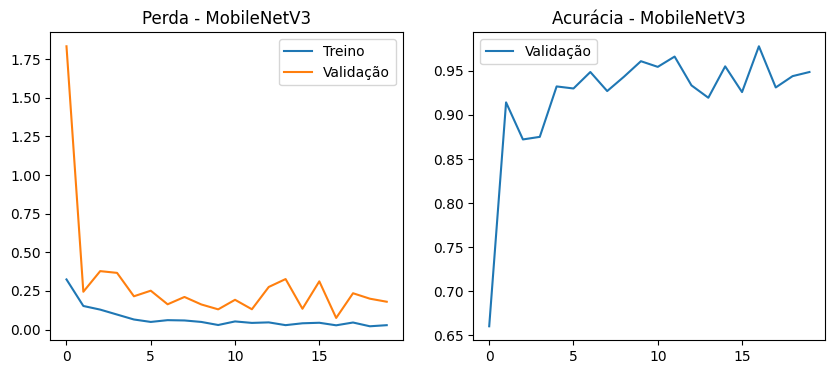


Relatório de Classificação - MobileNetV3:

              precision    recall  f1-score      support
glioma         1.000000  0.923333  0.960139   300.000000
meningioma     0.884956  0.980392  0.930233   306.000000
notumor        0.901566  0.995062  0.946009   405.000000
pituitary      0.995968  0.823333  0.901460   300.000000
accuracy       0.935927  0.935927  0.935927     0.935927
macro avg      0.945622  0.930530  0.934460  1311.000000
weighted avg   0.941816  0.935927  0.935366  1311.000000


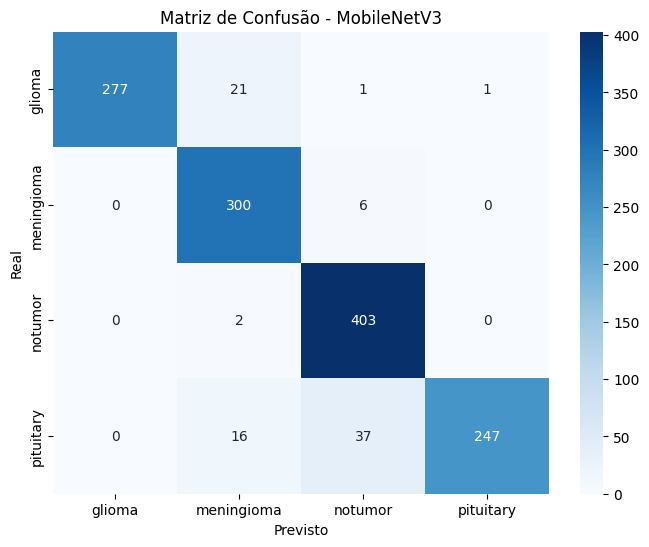

In [ ]:
print("\nTreinando MobileNetV3-Small...")

mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
mobilenet.classifier[3] = nn.Linear(mobilenet.classifier[3].in_features, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=learning_rate)

history_mobilenet = train_model(mobilenet, criterion, optimizer, num_epochs=num_epochs)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_mobilenet['train_loss'], label='Treino')
plt.plot(history_mobilenet['val_loss'], label='Validação')
plt.title('Perda - MobileNetV3')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mobilenet['val_acc'], label='Validação')
plt.title('Acurácia - MobileNetV3')
plt.legend()
plt.savefig("/content/MobileNetV3_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

test_model(mobilenet, train_dataset.classes, model_name="MobileNetV3")


Modelo 2: ResNet18

Treinando ResNet18 (substituindo ResNet18)...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Epoch [1/20] | Train Loss: 0.3889 | Val Acc: 0.9382
Epoch [2/20] | Train Loss: 0.2085 | Val Acc: 0.8477
Epoch [3/20] | Train Loss: 0.1622 | Val Acc: 0.8454
Epoch [4/20] | Train Loss: 0.1240 | Val Acc: 0.9224
Epoch [5/20] | Train Loss: 0.1385 | Val Acc: 0.9481
Epoch [6/20] | Train Loss: 0.1018 | Val Acc: 0.9282
Epoch [7/20] | Train Loss: 0.1096 | Val Acc: 0.9551
Epoch [8/20] | Train Loss: 0.0913 | Val Acc: 0.9662
Epoch [9/20] | Train Loss: 0.0569 | Val Acc: 0.9597
Epoch [10/20] | Train Loss: 0.0615 | Val Acc: 0.9638
Epoch [11/20] | Train Loss: 0.0585 | Val Acc: 0.9580
Epoch [12/20] | Train Loss: 0.0701 | Val Acc: 0.9539
Epoch [13/20] | Train Loss: 0.0518 | Val Acc: 0.9720
Epoch [14/20] | Train Loss: 0.0489 | Val Acc: 0.9638
Epoch [15/20] | Train Loss: 0.0661 | Val Acc: 0.9312
Epoch [16/20] | Train Loss: 0.0799 | Val Acc: 0.9609
Epoch [17/20] | Train Loss: 0.0316 | Val Acc: 0.9749
Epoch [18/20] | Train Loss: 0.0272 | Val Acc: 0.9749
Epoch [19/20] | Train Loss: 0.0441 | Val Acc: 0.9802
Ep

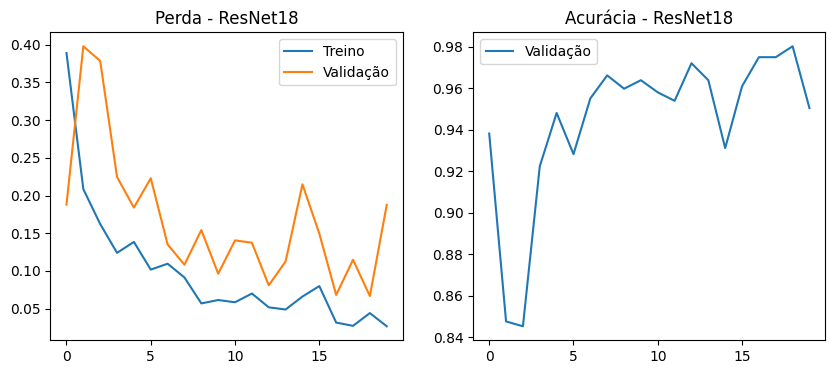


Relatório de Classificação - ResNet18:

              precision    recall  f1-score      support
glioma         0.898204  1.000000  0.946372   300.000000
meningioma     0.992982  0.924837  0.957699   306.000000
notumor        0.990196  0.997531  0.993850   405.000000
pituitary      0.992958  0.940000  0.965753   300.000000
accuracy       0.967963  0.967963  0.967963     0.967963
macro avg      0.968585  0.965592  0.965919  1311.000000
weighted avg   0.970427  0.967963  0.968118  1311.000000


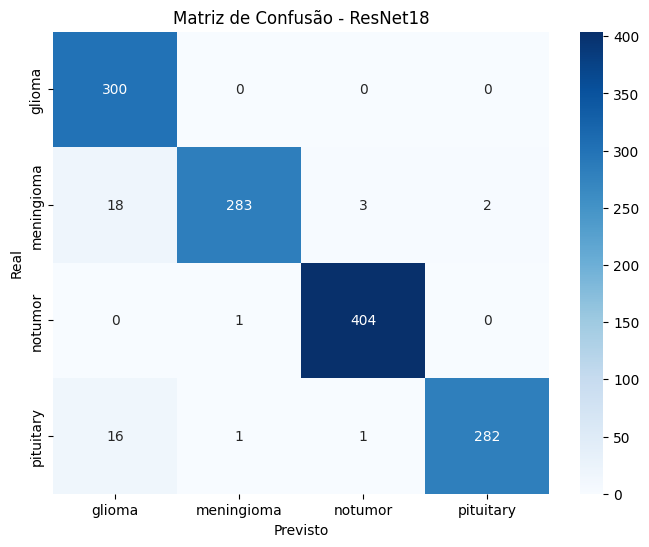

In [ ]:
print("Treinando ResNet18...")

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)

history_resnet18 = train_model(resnet18, criterion, optimizer, num_epochs=num_epochs)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_resnet18['train_loss'], label='Treino')
plt.plot(history_resnet18['val_loss'], label='Validação')
plt.title('Perda - ResNet18')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet18['val_acc'], label='Validação')
plt.title('Acurácia - ResNet18')
plt.legend()
plt.savefig("/content/ResNet18_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

test_model(resnet18, train_dataset.classes, model_name="ResNet18")

Comparações de modelo

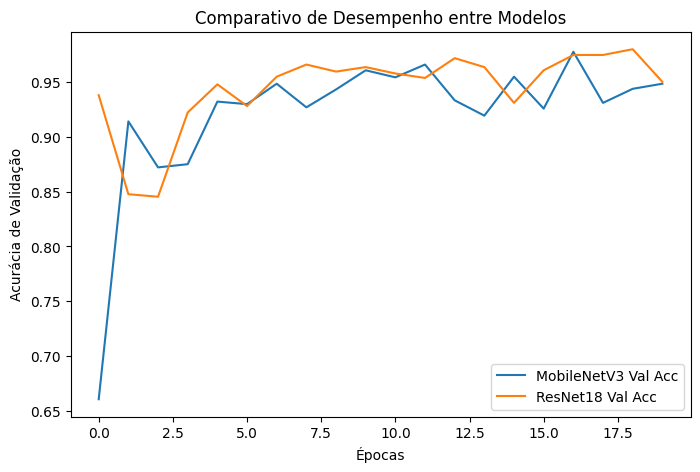

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_mobilenet['val_acc'], label='MobileNetV3 Val Acc')
plt.plot(history_resnet18['val_acc'], label='ResNet18 Val Acc')
plt.xlabel('Épocas')
plt.ylabel('Acurácia de Validação')
plt.title('Comparativo de Desempenho entre Modelos')
plt.legend()
plt.savefig("/content/comparativo_modelos.png", dpi=300, bbox_inches='tight')
plt.show()

history_df = pd.DataFrame({
    'epoch': list(range(1, num_epochs+1)),
    'mobilenet_val_acc': history_mobilenet['val_acc'],
    'resnet18_val_acc': history_resnet18['val_acc']
})

history_df.to_csv('/content/historico_treinamento.csv', index=False)

